In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
import obspy
from obspy.clients.fdsn import Client

client = Client("IRIS")

def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU), np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [2]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

# S0235b

In [15]:
begin = UTCDateTime('2019-07-26T12:19:19')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)


3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-07-26T12:09:19.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27320 samples
XB.ELYSE.02.BHN | 2019-07-26T12:09:19.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27320 samples
XB.ELYSE.02.BHZ | 2019-07-26T12:09:19.009000Z - 2019-07-26T12:32:04.959000Z | 20.0 Hz, 27320 samples

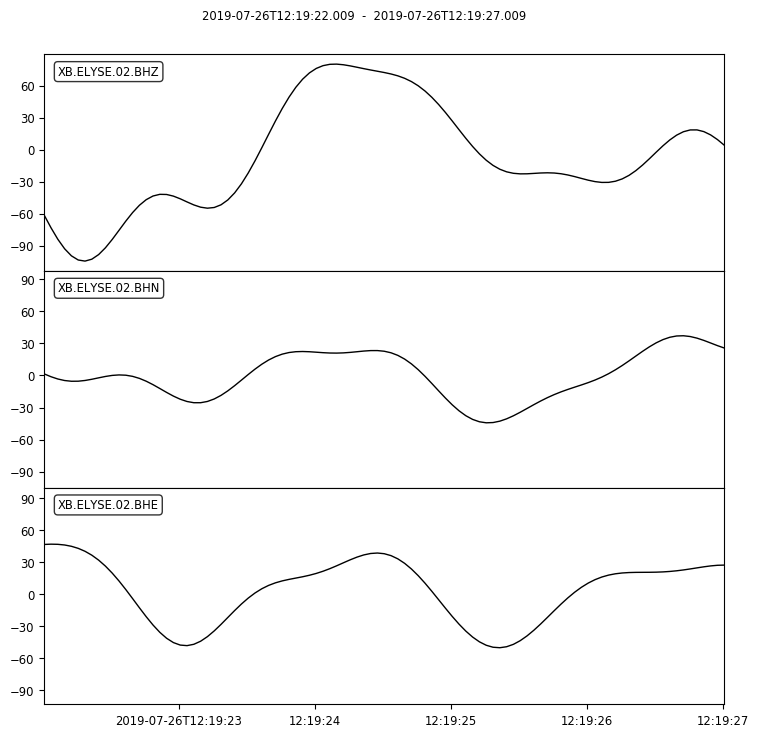

In [18]:
stP = stf.slice(starttime=begin+3,endtime=begin+8)
stP.plot();

In [19]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_74 = tval[np.where(alpha == 74)]
print(mina_74, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported as 74

[ 0.62269919] [ 0.32289609]
optimal angle =  55  or  -125


# S0173a

In [7]:
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)
    
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

3 Trace(s) in Stream:
XB.ELYSE.02.BHE | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHN | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples
XB.ELYSE.02.BHZ | 2019-05-23T02:12:59.031000Z - 2019-05-23T02:35:52.981000Z | 20.0 Hz, 27480 samples

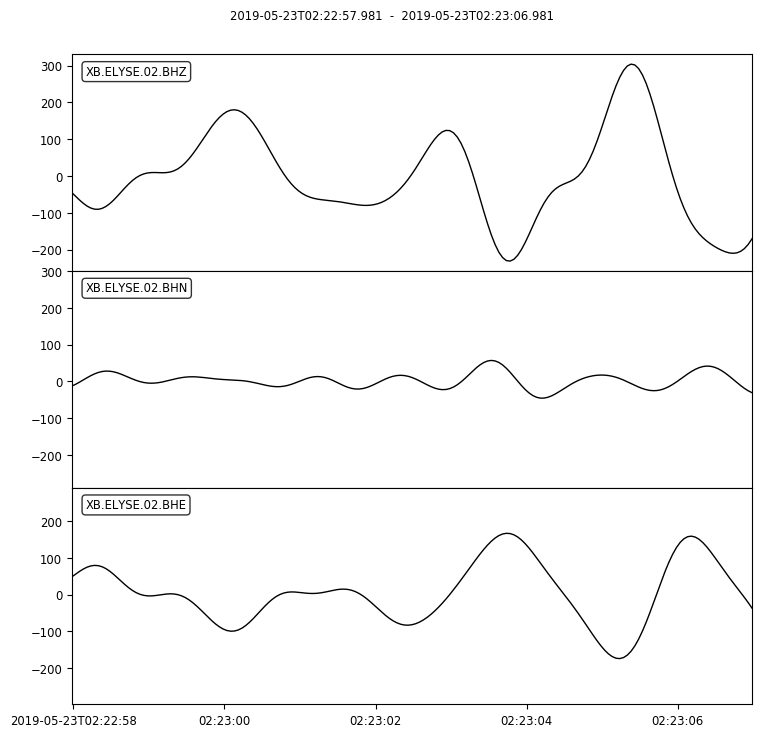

In [8]:
stP = stf.slice(starttime=begin-1,endtime=begin+8)
stP.plot();

In [9]:
scale = 1/400
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_91 = tval[np.where(alpha == 91)]
print(mina_91, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported 91 degrees

[ 0.49613583] [ 0.44164387]
optimal angle =  86  or  -94


# S0325b

<IPython.core.display.Javascript object>


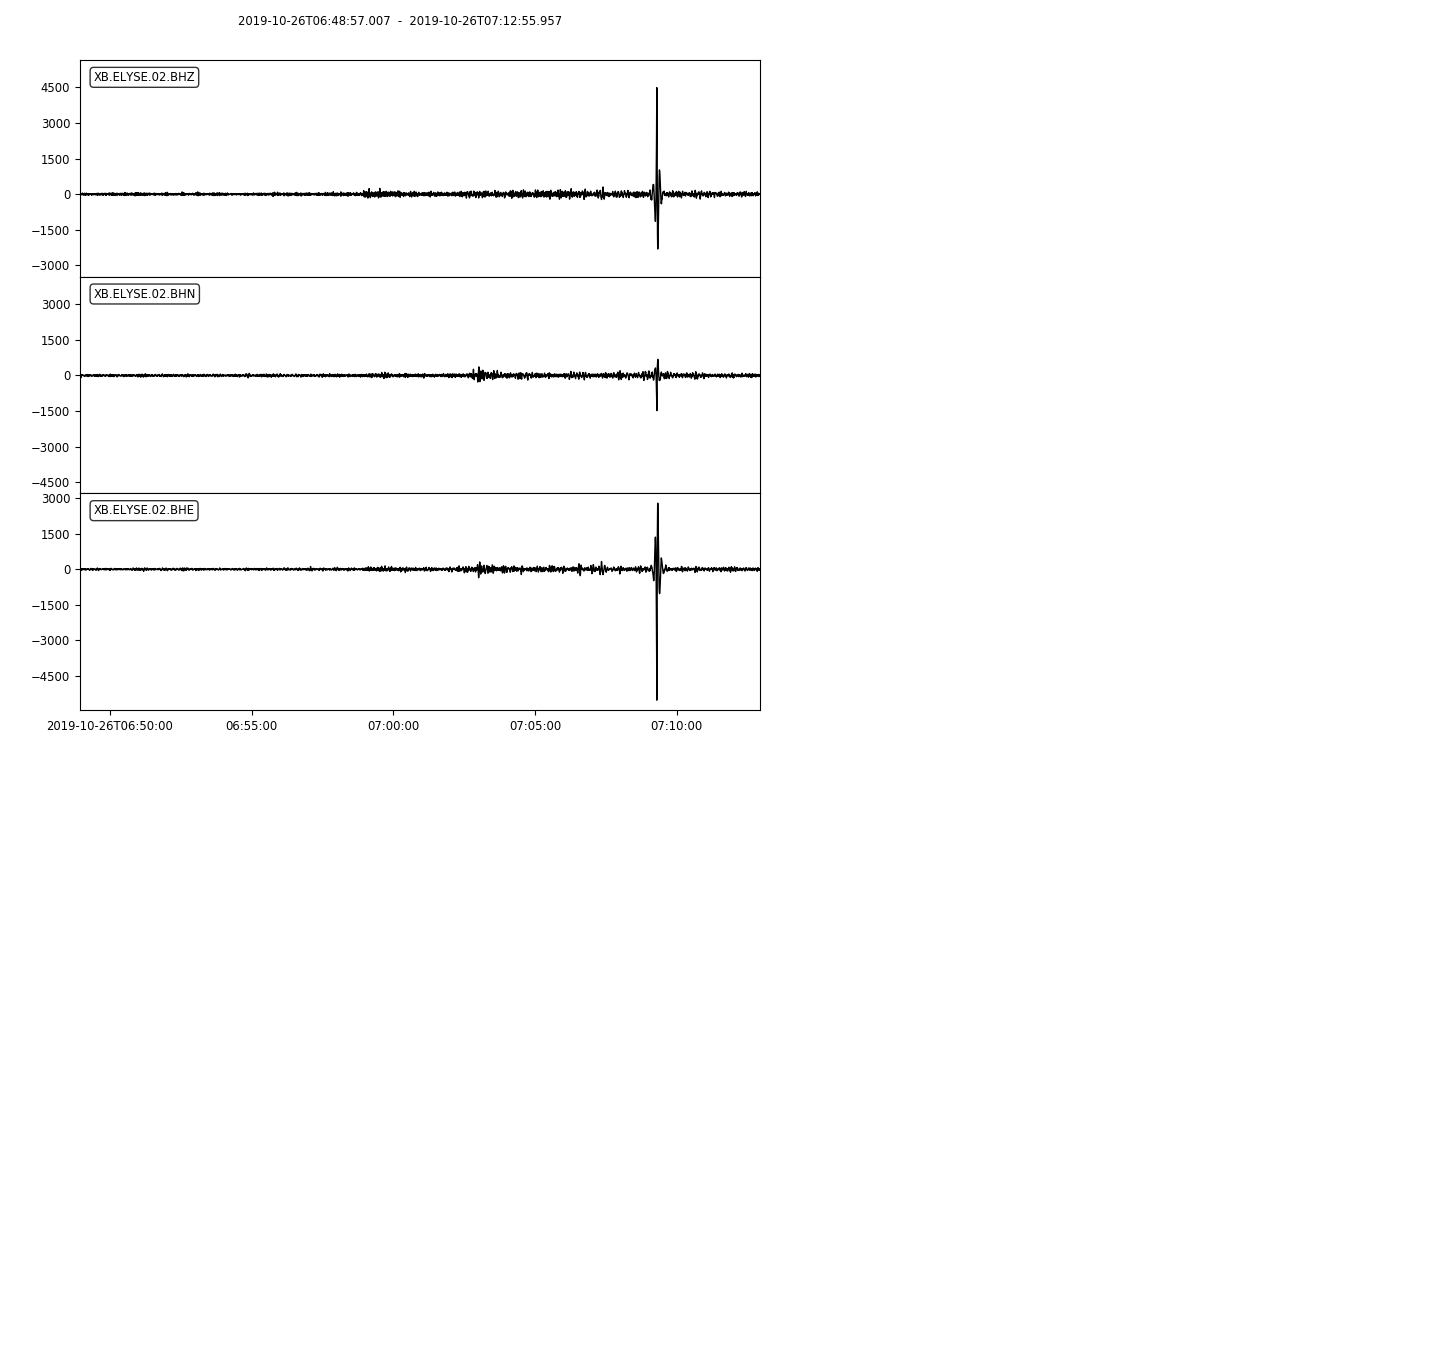

In [40]:
%matplotlib notebook
begin = UTCDateTime('2019-10-26T06:58:57')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:56')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stf.plot();

<IPython.core.display.Javascript object>


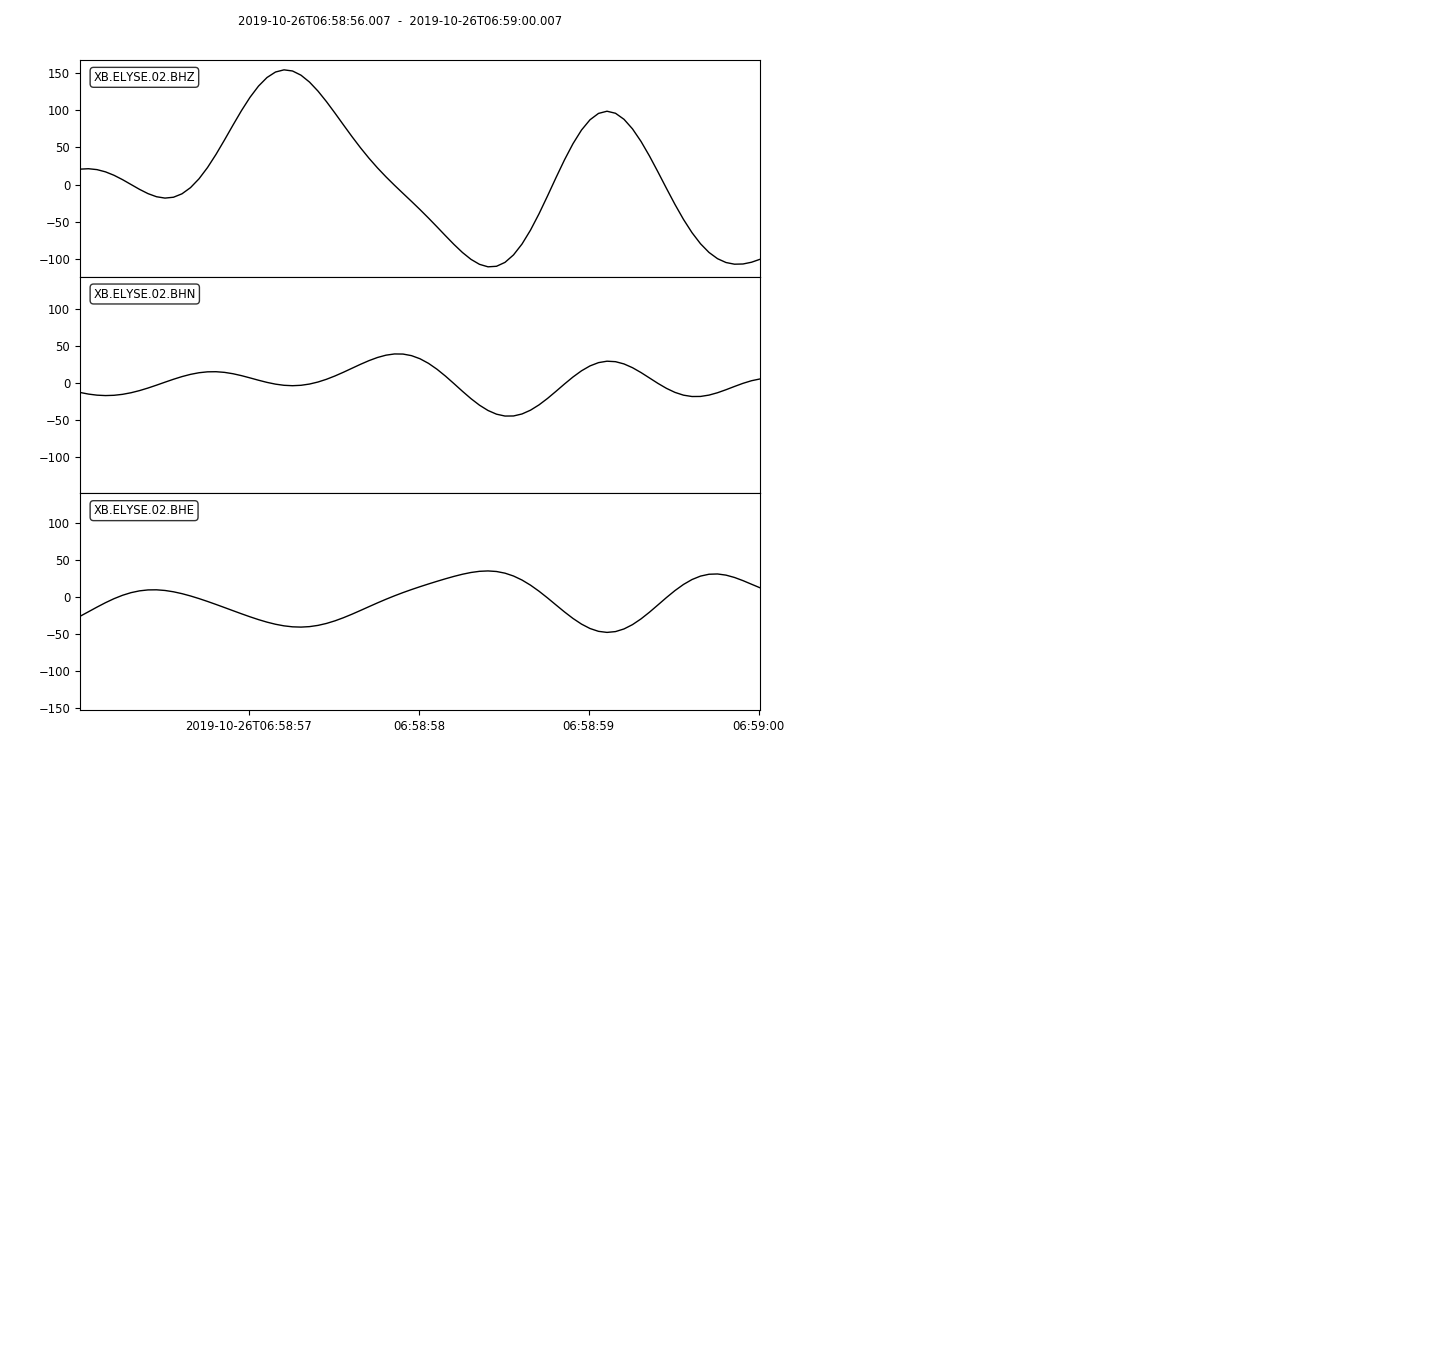

In [42]:
stP = stf.slice(starttime=begin-1,endtime=begin+3)
tvec = stP[0].times
stP.plot();

In [43]:
scale = 1/200
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 0.52475906]
optimal angle =  123  or  -57


# Rotation

<IPython.core.display.Javascript object>


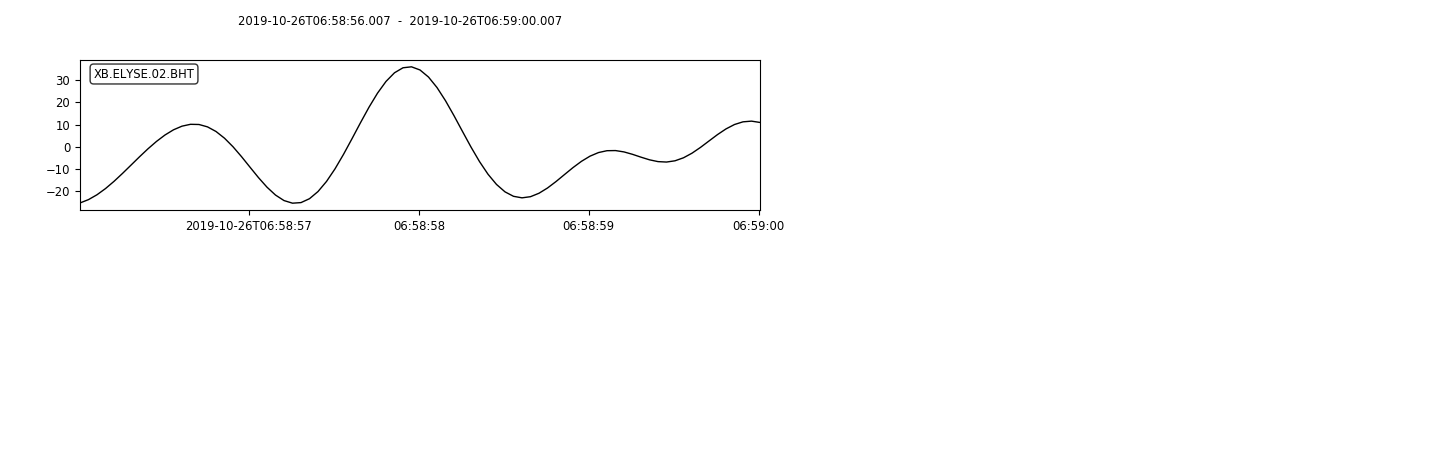

<IPython.core.display.Javascript object>


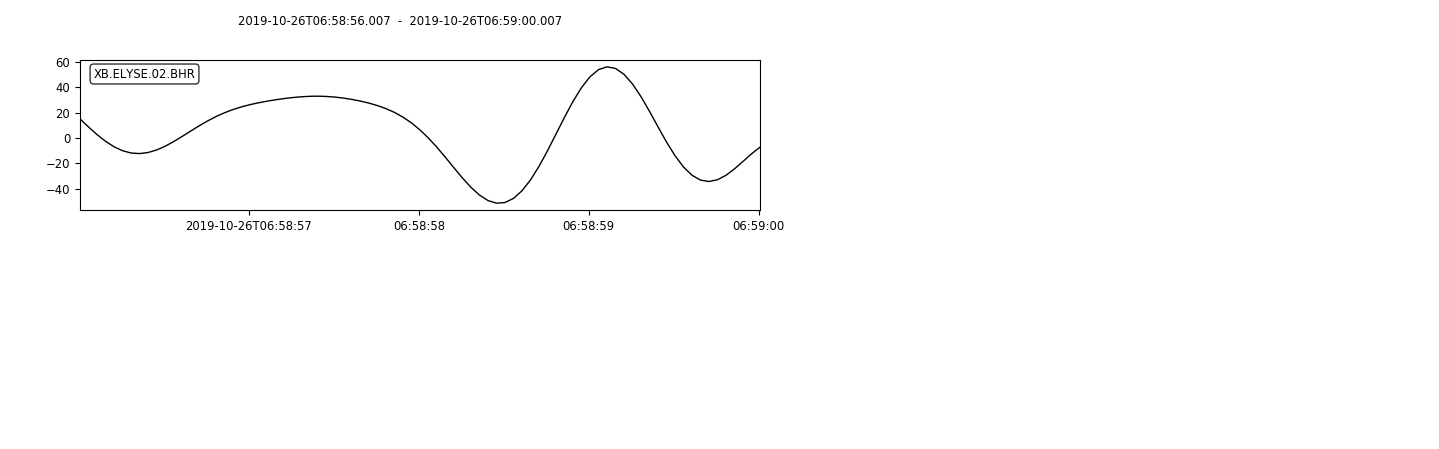

In [45]:
%matplotlib notebook
hhe = stP[0].data
hhn = stP[1].data
hhT,hhR = rotate(hhe,hhn,303)

streamRT = stP.copy()
streamRT[0].data = hhT
streamRT[1].data = hhR
streamRT[0].stats.component = 'T'
streamRT[1].stats.component = 'R'

streamRT[0].plot();
streamRT[1].plot();